In [2]:
# separate into training and validation


from PIL import Image
from torch.utils.data import Dataset, DataLoader
from glob import glob
from os import path
import json
from binascii import a2b_base64
from io import BytesIO
from PIL import Image
import torch
import torchvision
from torchvision import tv_tensors
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as T2

# Reference: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class GameDataset(Dataset):
    def __init__(self, data_folder_path, transforms=T2.Compose([T2.ToImage(), T2.ConvertImageDtype()])):
        self.files = []
        for file_name in glob(path.join(data_folder_path, '*.json')):
            self.files.append(file_name)
        
        self.transforms = transforms
        self.cache = {}

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):

        if index in self.cache:
            return self.transforms(self.cache[index])
        
        image_file = self.files[index]
        f = open(image_file)
        data = json.load(f)

        image_data = data['image'][22:]
        bytes = a2b_base64(image_data)
        bytes_io = BytesIO(bytes)
        image = Image.open(bytes_io).convert('RGB')

        bb = []
        labels = []
        shape = (image.size[1], image.size[0])
        merged_masks = torch.zeros(shape)
        
        for i in range(0,4):
            name = 'player{}'.format(i)
            if not name+'_pos' in data:
                continue
        
            pos = torch.tensor(data[name+'_pos']['data'])
            carriage_local = torch.tensor(data[name+'_carriage_local_pos']['data'])
            carriage_scale = torch.tensor(data[name+'_carriage_scale']['data'])
            
            cannon_local = torch.tensor(data[name+'_cannon_local_pos']['data'])
            cannon_scale = torch.tensor(data[name+'_cannon_scale']['data'])
            cannon_rotation = data[name+'_cannon_rotation']
            # todo use rotation to get a tighter bounding box
        
            cannon_top_left = pos + cannon_local
            carriage_top_left = pos + carriage_local
            
            cannon_bottom_right = cannon_top_left + cannon_scale
            carriage_bottom_right = carriage_top_left + carriage_scale
            
            top_left = [torch.min(cannon_top_left[0], carriage_top_left[0]), torch.min(cannon_top_left[1], carriage_top_left[1])]
            bottom_right = [torch.max(cannon_bottom_right[0], carriage_bottom_right[0]), torch.max(cannon_bottom_right[1], carriage_bottom_right[1])]
        
            x0 = int(top_left[0])
            y0 = int(top_left[1])
            x1 = int(bottom_right[0])
            y1 = int(bottom_right[1])
        
            merged_masks[y0:y1, x0:x1] = i+1
            labels.append(i+1)    
            bb.append(top_left + bottom_right)
        
        if 'rocket_pos' in data:
            pos =  torch.tensor(data['rocket_pos']['data'])
            scale =  torch.tensor(data['rocket_scale']['data'])
            local =  torch.tensor(data['rocket_local_pos']['data'])
            rotation =  torch.tensor(data['rocket_rotation'])
            # todo use rotation to get a tighter bounding box
            top_left = pos + local
            bottom_right = top_left + scale
        
            x0 = int(top_left[0])-10
            y0 = int(top_left[1])
            x1 = int(bottom_right[0])+10
            y1 = int(bottom_right[1])
        
            label = 5 # at most 4 players and 1 rocket
            merged_masks[y0:y1, x0:x1] = label
            labels.append(label)
            bb.append([x0, y0, x1, y1])
        
        labels = torch.tensor(labels)
        bb = tv_tensors.BoundingBoxes(torch.tensor(bb), format='XYXY', canvas_size=shape)
        mask_labels = labels
        masks = tv_tensors.Mask(merged_masks == mask_labels.view(-1, 1, 1))
        
        target = {
            'boxes': bb,
            'labels': labels,
            'masks': masks
        }

        self.cache[index] = (image, target)
        image, target = self.transforms(image, target)
        return image, target

len: 155
image shape: torch.Size([3, 240, 320])
target: dict_keys(['boxes', 'labels', 'masks'])
mask shape: torch.Size([5, 240, 320])
merged torch.Size([240, 320])
unique mask values: tensor([False,  True])
labels tensor([1, 2, 3, 4, 5])


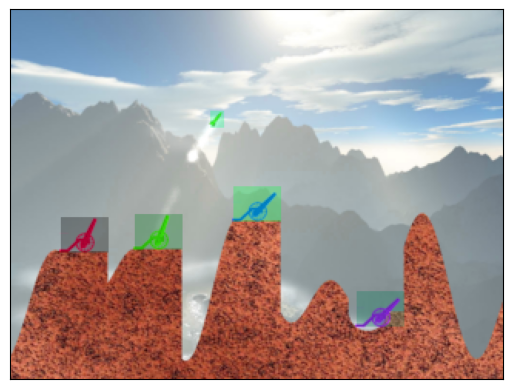

In [3]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms.v2 import functional as F
from pylab import show, subplots

test_transforms = T2.Compose([
    T2.Resize(240, antialias=True),
    T2.ToImage(),
    T2.RandomPhotometricDistort(),
    T2.RandomHorizontalFlip(),
    T2.SanitizeBoundingBoxes(),
])

dataset = GameDataset('train/', transforms=test_transforms)
image, target = dataset[7]
print('len:', len(dataset))
print('image shape:', image.shape)
print('target:', target.keys())
print('mask shape:', target['masks'].shape)
print('merged', torch.sum(target['masks'], 0).shape)
print('unique mask values:', torch.unique(target['masks']))
print('labels', target['labels'])

bb = target['boxes']
masks = target['masks']

result = draw_bounding_boxes(image, bb, width=4)
result = draw_segmentation_masks(image, masks, alpha=.3)

result = result.detach()
result = F.to_pil_image(result)
fig, axs = subplots(1, 1)
axs.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs.imshow(result, interpolation=None)

In [4]:
import torch.nn as nn

# EfficientNet https://arxiv.org/pdf/1905.11946.pdf
# MobileNet https://arxiv.org/abs/1801.04381
# https://arxiv.org/pdf/2008.02170.pdf

class ObjectDetector(nn.Module):

    class Block(nn.Module):
        def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
            super().__init__()
            self.layers = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(True)
            )

        def forward(self, x):
            result = self.layers(x)
            return result
    
    class DownBlock(nn.Module):
        def __init__(self, channels, kernel_size=4, stride=2, padding=1):
            super().__init__()
            self.layers = nn.Sequential(
                # Halve the w/h
                #nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
                # double the channels
                nn.Conv2d(channels, channels*2, kernel_size, stride, padding),
                nn.BatchNorm2d(channels*2),
                nn.ReLU(True)
            )

        def forward(self, x):
            result = self.layers(x)
            return result

    class UpBlock(nn.Module):
        def __init__(self, channels, kernel_size=4, stride=2, padding=1):
            super().__init__()
            self.layers = nn.Sequential(
                #  halve the channels, Double the w/h
                nn.ConvTranspose2d(channels, channels//2, kernel_size, stride, padding),
                nn.BatchNorm2d(channels//2),
                nn.ReLU(True)
            )

        def forward(self, x):
            result = self.layers(x)
            return result

    # https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/2ecf15f8a7f87fa56e784e0504136e9daf6b93d6/models/networks.py#L259
    class USkipConnectionBlock(nn.Module):
        def __init__(self, outer_channels, inner_channels, submodule=None):
            super().__init__()
            
            left = ObjectDetector.Block(outer_channels, outer_channels)
            down = ObjectDetector.DownBlock(outer_channels)

            model = []
            if submodule == None:
                up = ObjectDetector.UpBlock(inner_channels)
                inner = ObjectDetector.Block(inner_channels, inner_channels)
                right = ObjectDetector.Block(2*inner_channels, outer_channels)
                model = [left, down, inner, up]
            else:
                up = ObjectDetector.UpBlock(inner_channels)
                right = ObjectDetector.Block(2*inner_channels, 2*outer_channels)
                model = [left, down, submodule, right, up]
            
            self.model = nn.Sequential(*model)

        def forward(self, x):
            output = self.model(x)
            result = torch.cat([x, output], dim=1)
            return result

    def __init__(self):
        super().__init__()

        c0 = 4
        c1 = c0*2
        c2 = c1*2
        c3 = c2*2
        #uBlocks = ObjectDetector.USkipConnectionBlock(outer_channels=c2, inner_channels=c3, submodule=None)
        uBlocks = ObjectDetector.USkipConnectionBlock(outer_channels=c1, inner_channels=c2, submodule=None)
        uBlocks = ObjectDetector.USkipConnectionBlock(outer_channels=c0, inner_channels=c1, submodule=uBlocks)

        self.backbone = nn.Sequential(
            self.Block(in_channels=3, out_channels=c0),
            uBlocks,
            self.Block(in_channels=c1, out_channels=c0),
        )

        num_classes = 1 # cannons and rockets
        self.segmentation = nn.Conv2d(in_channels=c0, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        logits = self.backbone(x)
        return self.segmentation(logits)


model = ObjectDetector()
print(model)


ObjectDetector(
  (backbone): Sequential(
    (0): Block(
      (layers): Sequential(
        (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): USkipConnectionBlock(
      (model): Sequential(
        (0): Block(
          (layers): Sequential(
            (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
        )
        (1): DownBlock(
          (layers): Sequential(
            (0): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
            (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
        )
        (2): USkipConnectionBlock(
          (model): Sequentia

In [5]:
# Test the e2e with the dataset and the model
transforms = T2.Compose([
    T2.Resize(240, antialias=True),
    T2.ToImage(),
    T2.ConvertImageDtype(),
    T2.RandomPhotometricDistort(),
    T2.RandomHorizontalFlip(),
    T2.SanitizeBoundingBoxes(),
])

dataset = GameDataset('train/', transforms)
image, target = dataset[0]
print(image.shape)
model = ObjectDetector()
model.eval()
batch = image[None]
output = model(batch)
print(output[0].shape)


torch.Size([3, 240, 320])
torch.Size([1, 240, 320])


In [9]:
# times vary on my CPU based on battery, temperature, CPU availability, memory usage
%timeit model(batch)

23.6 ms ± 3.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
# train model with tensorboard vizualization
import torch.utils.tensorboard as tb
%load_ext tensorboard
i = 1

In [12]:
log_base = 'log{}'.format(i)
i+=1

In [13]:
%reload_ext tensorboard
%tensorboard --logdir {log_base} --reload_interval 0.1 --port 8018

In [14]:
j=5
log_base, j

('log1', 5)

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# From ChatGPT :)
# https://arxiv.org/abs/1708.02002
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # calculate the probability for each class
        focal_loss = (self.alpha * (1 - pt) ** self.gamma * BCE_loss).mean()
        return focal_loss

def train(run_num):
    logs_dir = log_base
    model = ObjectDetector()
    train_logger = tb.SummaryWriter(path.join(logs_dir, 'train{}'.format(run_num)), flush_secs=1)
    valid_logger = tb.SummaryWriter(path.join(logs_dir, 'valid{}'.format(run_num)), flush_secs=1)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
    
    train_transforms = T2.Compose([
        T2.Resize(240, antialias=True),
        T2.ToImage(),
        T2.ConvertImageDtype(),
        T2.RandomPhotometricDistort(),
        T2.RandomHorizontalFlip(),
        #T2.SanitizeBoundingBoxes(),
    ])

    valid_transforms = T2.Compose([
        T2.Resize(240, antialias=True),
        T2.ToImage(),
        T2.ConvertImageDtype(),
        #T2.SanitizeBoundingBoxes(),
    ])

    train_dataset = GameDataset('train/', train_transforms)
    valid_dataset = GameDataset('valid/', valid_transforms)
    # Use num_workers=0 because multiprocess loader is not working on Windows + jupyter notebook
    training_data = DataLoader(train_dataset, num_workers=0, batch_size=2, shuffle=True)
    validation_data = DataLoader(valid_dataset, num_workers=0, batch_size=2, shuffle=True)
    model.train()

    loss_fn = FocalLoss() # nn.MSELoss()

    torch.autograd.set_detect_anomaly(True)

    optimizer = torch.optim.SGD(
        model.parameters(),
        momentum=0.9,
        lr=.1,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    optimizer.zero_grad()

    global_step = 0
    for epoch in range(20):
        model.train()
        for index, batch in enumerate(training_data):
            images, target = batch
            target_masks = target['masks'].sum(dim=1, keepdim=True)

            predicted_masks = model(images)
            loss = loss_fn(predicted_masks, target_masks)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if global_step % 10 == 0:
                train_logger.add_scalar('loss', loss, global_step=global_step)
                with torch.no_grad():
                    image, target = validation_data.dataset[7]
                    predicted_mask = model(image[None])[0]
                    combined = predicted_mask.sum(dim=0).sigmoid()
                    jet_colormap = plt.colormaps['jet']
                    colored_image = jet_colormap(combined.cpu().numpy())
                    colored_image = torch.from_numpy(colored_image).permute(2, 0, 1)                   
                    valid_logger.add_image('mask', (colored_image*255).byte(), global_step=global_step)
            
            global_step += 1

        model.eval()
        torch.save(model.state_dict(), 'detector.pt')
        val_losses = []
        with torch.no_grad():
            for index, batch in enumerate(validation_data):
                images, target = batch
                predicted_masks = model(images)
                validation_loss = loss_fn(predicted_masks, target['masks'].sum(dim=1, keepdim=True))
                val_losses.append(validation_loss)

        avg_validation_loss = torch.mean(torch.tensor(val_losses))
        valid_logger.add_scalar('loss', avg_validation_loss, global_step=global_step)
        scheduler.step(avg_validation_loss)
        
    return model

j = j+1
model = train(j)
torch.save(model.state_dict(), 'detector.pt')


torch.Size([1, 240, 320])


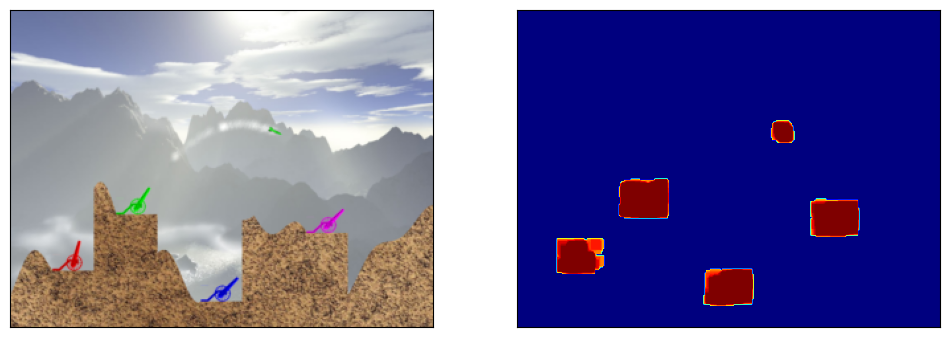

In [10]:
# view model output

import torch
from torchvision.transforms.v2 import functional as F
import torch.nn.functional as nnf
from pylab import show, subplots


model = ObjectDetector()
model.load_state_dict(torch.load('detector.pt'))
#model.load_state_dict(torch.load('detector-backup-unet.pt'))
model.eval()

validation_transforms = T2.Compose([
    T2.Resize(240, antialias=True),
    T2.ToImage(),
    T2.ConvertImageDtype(),
    #T2.SanitizeBoundingBoxes(),
])

dataset = GameDataset('valid/', validation_transforms)
image, target = dataset[7]
batch = image[None]
predicted_mask = model(batch)

sigmoid = predicted_mask.sum(dim=1).sigmoid()
mask_max = nnf.max_pool2d(sigmoid, kernel_size=7, padding=3, stride=1)
threshold = mask_max.max()*.7
mask_max[mask_max<threshold]=0

islands=mask_max
print(predicted_mask[0].shape)


fig, axs = subplots(1, 2, figsize=(12,6))

axs[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs[0].imshow(F.to_pil_image(image), interpolation=None, cmap='jet')
axs[1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs[1].imshow(F.to_pil_image(islands), interpolation=None, cmap='jet')


# More References

http://pytorch.org/vision/main/transforms.html
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
http://pytorch.org/vision/main/transforms.html
https://pytorch.org/vision/stable/index.html
http://pytorch.org/vision/main/transforms.html
http://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py
http://pytorch.org/vision/main/feature_extraction.html
http://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_e2e.html#sphx-glr-auto-examples-transforms-plot-transforms-e2e-py

https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html
https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

https://pytorch.org/vision/stable/transforms.html

http://pytorch.org/vision/main/feature_extraction.html

https://pytorch.org/vision/master/generated/torchvision.tv_tensors.BoundingBoxes.html#:~:text=BoundingBoxes%20class%20torchvision.tv_tensors.BoundingBoxes%28data%3A%20Any%2C%20%2A%2C%20format%3A%20Union%5BBoundingBoxFormat%2C%20str%5D%2C,None%29%20%5Bsource%5D%20%5BBETA%5D%20torch.Tensor%20subclass%20for%20bounding%20boxes.

https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
